# Imports

### python libraries

In [ ]:
import csv # for importing and working with .csv files
import matplotlib.pyplot as plt # for plotting
import scipy.fft as spfft # for functions such as fft
import scipy.signal as spsig # for signal processing (filtering)
import tensorflow as tf # for machine learning using tensorflow keras
import pandas as pd

## Live loadcell feedback

In [ ]:

# Open the serial communication
serialCom = serial.Serial('COM3', 9600) # change baudrate and port as needed
serialCom.setDTR(False)
time.sleep(1)
serialCom.flushInput()
serialCom.setDTR(True)

# Initialize DataFrame add more colums when more sensors are added
columns = ['Timestamp','LeftFootName', 'InsideLeft','OutsideLeft','HeelLeft', 'RightFootName','InsideRight','OutsideRight','HeelRight', 'DistanceName','Distance']
df = pd.DataFrame(columns=columns)

# Initialize figure and axis
fig, ax = plt.subplots()
plt.ion()  # Turn on interactive mode

def draw_feet(InsideLeft,OutsideLeft,HeelLeft,InsideRight,OutsideRight,HeelRight):
    """Draws feet visualization with circles based on the latest dataframe values."""
    if df.empty:
        return
    
    # Get the latest row
    latest_row = df.iloc[-1]
    
    
    # Clear the figure
    ax.clear()
    ax.set_xlim(-2, 2)
    ax.set_ylim(-3, 1)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Draw feet outline
    foot_left = plt.Circle((-1, -1), 1, edgecolor='black', facecolor='none', linewidth=2)
    foot_right = plt.Circle((1, -1), 1, edgecolor='black', facecolor='none', linewidth=2)
    ax.add_patch(foot_left)
    ax.add_patch(foot_right)
    
    
    # Calculate circle RGB values
    colors = [
        (1 - float(InsideLeft), float(InsideLeft), 0),
        (1 - float(OutsideLeft), float(OutsideLeft), 0),
        (1 - float(HeelLeft), float(HeelLeft), 0),
        (1 - float(InsideRight), float(InsideRight), 0),
        (1 - float(OutsideRight), float(OutsideRight), 0),
        (1 - float(HeelRight), float(HeelRight), 0)
    ]
    
    # Circle positions relative to feet
    positions = [(-0.8, -0.4), (-1.5, -0.6), (-1, -1.5), (0.8, -0.4), (1.5, -0.6), (1, -1.5)]
    
    # Draw circles
    for i, (x, y) in enumerate(positions):
        circle = plt.Circle((x, y), 0.2, edgecolor='black', facecolor=colors[i])
        ax.add_patch(circle)
    
    plt.draw()
    plt.pause(0.1)  # Pause to update the plot

# function to normalize a column of the dataframe
def normalize_column(column, max_value, min_value):
    """Normalizes a column of the dataframe."""
    if max_value - min_value == 0:
        return 0
    return (column - min_value) / (max_value - min_value)

# store the maximum and minimum values for each sensor
# these values are used to normalize the data
maximums = {
    'InsideLeft': 0, 'OutsideLeft': 0, 'HeelLeft': 0,
    'InsideRight': 0, 'OutsideRight': 0, 'HeelRight': 0
}
minimums = {
    'InsideLeft': 0, 'OutsideLeft': 0, 'HeelLeft': 0,
    'InsideRight': 0, 'OutsideRight': 0, 'HeelRight': 0
}

# Live update loop, exit with keyboard interrupt (Ctrl+C)
while True:
    try:
        # read line and decode it
        s_bytes = serialCom.readline()
        # decode the bytes to string and strip the new line characters
        decoded_bytes = s_bytes.decode("utf-8").strip('\r\n')
        # split the string into a list of values
        values = decoded_bytes.split(' ')
        # check if the number of values is equal to the number of columns
        if len(values) == len(columns):
            # create a new row with the values
            row = pd.DataFrame([values], columns=columns)
            
            #append the new row to the dataframe
            df = pd.concat([df, row], ignore_index=True) 

            # detect if the new values are higher or lower than the previous maximum or minimum
            for column in ['InsideRight','OutsideRight', 'HeelRight','InsideLeft','OutsideLeft', 'HeelLeft']:
                # update the maximum and minimum values if the new value is higher or lower, and if it is either normalize the entire column
                normalizeBoolean = False
                if float(row[column].values[0]) > maximums[column]:
                    maximums[column] = float(row[column].values[0])
                    normalizeBoolean = True
                if float(row[column].values[0]) < minimums[column]:
                    minimums[column] = float(row[column].values[0])
                    normalizeBoolean = True
                if normalizeBoolean:
                    # normalize the entire column using the function above
                    df[column] = df[column].apply(lambda x: normalize_column(float(x), maximums[column], minimums[column]))
                    


        

            # and normalize the columns using the function above
            for column in ['InsideRight','OutsideRight', 'HeelRight','InsideLeft','OutsideLeft', 'HeelLeft']:
                df[column] = df[column].apply(lambda x: normalize_column(float(x), maximums[column], minimums[column]))
            
        

                    
            draw_feet(df)
    except Exception as e:
        print(f"Error: {e}")
        continue

## Data from Files

### creating csv file from txt serial logger output 

In [ ]:
# reading txt file and separating with spaces
file_name = '3LoadCells_2'
log_df = pd.read_csv(f"Logging/ExampleLogs/{file_name}.txt", header = None, delimiter=' ') 
  
# adding column headings 
log_df.columns = ['Timestamp', 'cell1', 'load1','cell2', 'load2','cell3', 'load3'] 

# dropping unnececary columns
log_df = log_df.drop(columns=['cell1', 'cell2','cell3'])

# store log_dfframe as csv
log_df.to_csv(f'Logging/{file_name}.csv', index = None) 
display(log_df)

,Timestamp,load1,load2,load3
0,11:13:32.857,2,-6,0
1,11:13:32.956,5,-3,5
2,11:13:33.034,-16,0,0
3,11:13:33.148,-9,2,6
4,11:13:33.240,13,1,6
...,...,...,...,...
319,11:14:03.654,22,70,232
320,11:14:03.747,29,66,230
321,11:14:03.858,7,77,251
322,11:14:03.940,20,62,234


### Plotting collected log_df

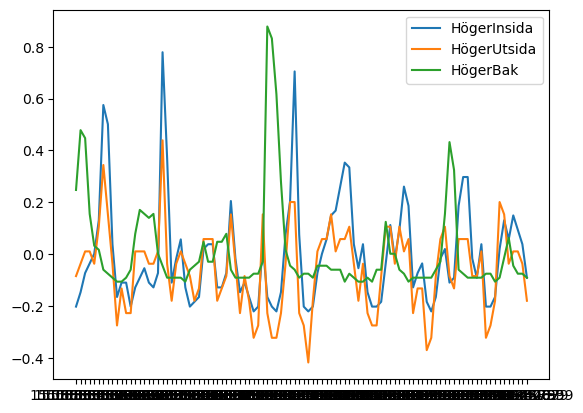

In [12]:
# reading txt file and separating with spaces
file_name = 'FullSetup_LegSwing'
log_df = pd.read_csv(f"Logging/ExampleLogs/{file_name}.txt", header = None, delimiter=' ') 
  
# adding column headings 
log_df.columns = ['Timestamp', 'Foot_H', 'loadcell1H','loadcell2H', 'loadcell3H','fel','Foot_V','loadcell1V','loadcell2V', 'loadcell3V', 'DistanceName', 'Distance'] 

# dropping unnececary columns
log_df = log_df.drop(columns=['Foot_H', 'Foot_V','DistanceName','fel'])

#plt.plot(log_df['Timestamp'], log_df['loadcell1H']-log_df['loadcell1H'].mean(),label="HögerInsida")
#plt.plot(log_df['Timestamp'], log_df['loadcell2H']-log_df['loadcell2H'].mean(),label="HögerUtsida")
#plt.plot(log_df['Timestamp'], log_df['loadcell3H']-log_df['loadcell3H'].mean(),label="HögerBak")
#plt.plot(log_df['Timestamp'], log_df['loadcell1V']-log_df['loadcell1V'].mean(),label="VänsterInsida")
#plt.plot(log_df['Timestamp'], log_df['loadcell2V']-log_df['loadcell2V'].mean(),label="VänsterUtsida")
#plt.plot(log_df['Timestamp'], log_df['loadcell3V']-log_df['loadcell3V'].mean(),label="VänserBak")
plt.plot(log_df['Timestamp'], log_df['Distance'],label="Avstånd")
plt.gca().set_axis_off()
plt.legend()
plt.show()


In [ ]:
# printing the length of the dataframe
print(len(log_df))
print(log_df["Timestamp"].iloc[0])
print(log_df["Timestamp"].iloc[-1])
# 240 + 7 = 247 / 2642 = 0.0935


2642
15:05:28.419
15:09:22.899


TypeError: unsupported operand type(s) for -: 'str' and 'str'

## Feet LoadCell Visualisation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
file_name = 'FullSetup_Walking'
log_df = pd.read_csv(f"Logging/ExampleLogs/{file_name}.txt", header = None, delimiter=' ') 
  
# adding column headings 
log_df.columns = ['Timestamp', 'Foot_V', 'loadcell1V','loadcell2V', 'loadcell3V','fel','Foot_H','loadcell1H','loadcell2H', 'loadcell3H', 'DistanceName', 'Distance'] 

# dropping unnececary columns
log_df = log_df.drop(columns=['Foot_H', 'Foot_V','DistanceName','fel']) # "fel" is because of an unnecesary space, fixed in code so remove when no longer using outdated data

# normalize data columns
ScaleColumns = ("loadcell1H",'loadcell2H', 'loadcell3H','loadcell1V','loadcell2V', 'loadcell3V')
for column in ScaleColumns:
    log_df[column] = (log_df[column] - log_df[column].min()) / (log_df[column].max() - log_df[column].min())

def draw_feet(value_index):
    # Calculate circle RGB value
    colors = [
        (1 - float(log_df.loc[value_index, 'loadcell1V']), float(log_df.loc[value_index, 'loadcell1V']), 0),
        (1 - float(log_df.loc[value_index, 'loadcell2V']), float(log_df.loc[value_index, 'loadcell2V']), 0),
        (1 - float(log_df.loc[value_index, 'loadcell3V']), float(log_df.loc[value_index, 'loadcell3V']), 0),
        (1 - float(log_df.loc[value_index, 'loadcell1H']), float(log_df.loc[value_index, 'loadcell1H']), 0),
        (1 - float(log_df.loc[value_index, 'loadcell2H']), float(log_df.loc[value_index, 'loadcell2H']), 0),
        (1 - float(log_df.loc[value_index, 'loadcell3H']), float(log_df.loc[value_index, 'loadcell3H']), 0)
    ]
    
    # figure setup
    fig, ax = plt.subplots()
    ax.set_xlim(-2, 2)
    ax.set_ylim(-3, 1)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Draw feet outline
    foot_left = plt.Circle((-1, -1), 1, edgecolor='black', facecolor='none', linewidth=2)
    foot_right = plt.Circle((1, -1), 1, edgecolor='black', facecolor='none', linewidth=2)
    ax.add_patch(foot_left)
    ax.add_patch(foot_right)
    
    # Circle positions relative to feet
    positions = [(-0.8, -0.4), (-1.5, -0.6), (-1, -1.5), (0.8, -0.4), (1.5, -0.6), (1, -1.5)]
    
    # Draw circles
    for i, (x, y) in enumerate(positions):
        circle = plt.Circle((x, y), 0.2, edgecolor='black', facecolor=colors[i])
        ax.add_patch(circle)
    plt.show()

# Create slider
interact(draw_feet, value_index=IntSlider(min=0, max=log_df['Timestamp'].shape[0]-1, step=1, value=0));


interactive(children=(IntSlider(value=2000, description='value_index', max=2100, min=2000), Output()), _dom_cl…

<function __main__.draw_feet(value_index)>

## Fourier transform on signals
We preform the fourier transform in order to see what frequencies we might want to filter out.
https://docs.scipy.org/doc/scipy/tutorial/fft.html

Sampling rate: 9.615384615384615 Hz


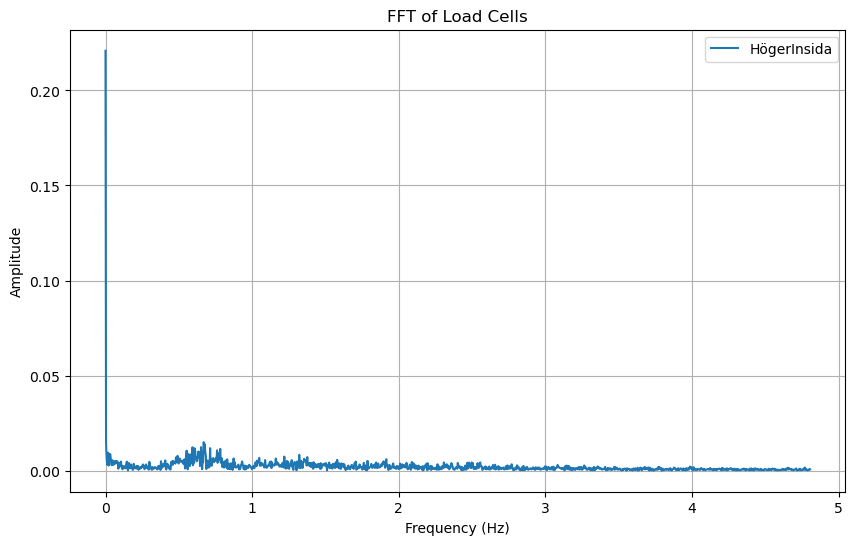

In [ ]:
# calculate the frequency of the data colected from the timestamps
sampling_rate = 1 / (log_df["Timestamp"].iloc[1] - log_df["Timestamp"].iloc[0]).total_seconds() # Hz
n_samples = len(log_df["Timestamp"]) # number of samples
duration = n_samples / sampling_rate # seconds
# calculate the frequency of the data collected from the timestamps
frequency = np.fft.fftfreq(n_samples, d=1/sampling_rate) # frequency in Hz
print(f"Sampling rate: {sampling_rate} Hz")
# calculate the FFT of the data for every loadcell with a for loop
FFT = {}
for column in ScaleColumns:
    FFT[column] = np.fft.fft(log_df[column])
    FFT[column] = np.abs(FFT[column]) / n_samples # normalize the FFT
    FFT[column] = FFT[column][:n_samples // 2] # take only the positive frequencies
    frequency = frequency[:n_samples // 2] # take only the positive frequencies
# plot the FFT of a single loadcell
plt.figure(figsize=(10, 6))
plt.plot(frequency, FFT['loadcell1H'], label='HögerInsida') # plot the FFT of the loadcell
plt.legend() # plot the legend
plt.xlabel('Frequency (Hz)') # x-axis label
plt.ylabel('Amplitude') # y-axis label
plt.title('FFT of Load Cells') # title of the plot
plt.grid()
plt.show()


## Filtering
Using filters a lot of the noise from the different signals can be removed.
https://docs.scipy.org/doc/scipy/reference/signal.html

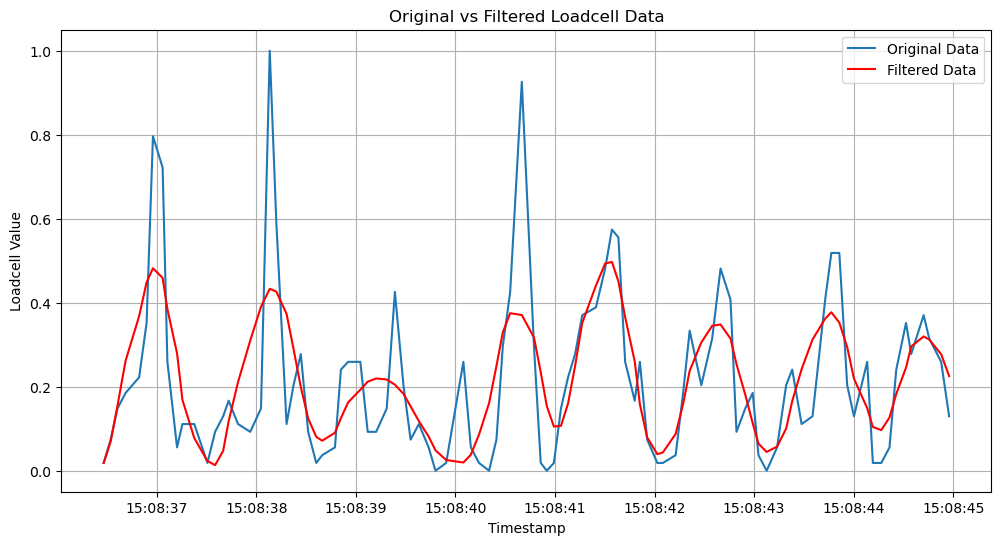

In [94]:
# Signal filtering using scipy.signal
def filter_signal(data, cutoff_freq, sampling_rate, filter_order=4):
    """Applies a low-pass Butterworth filter to the data."""
    nyquist = 0.5 * sampling_rate
    if cutoff_freq >= nyquist:
        raise ValueError(f"Cutoff frequency must be less than the Nyquist frequency ({nyquist} Hz).")
    normal_cutoff = cutoff_freq / nyquist
    b, a = spsig.butter(filter_order, normal_cutoff, btype='low', analog=False)
    filtered_data = spsig.filtfilt(b, a, data)
    return filtered_data

# use the filter_signal function to filter the loadcell data
cutoff_freq = 1  # cutoff frequency in Hz
try:
    # Filter the loadcell data
    filtered_data = filter_signal(log_df['loadcell1H'], cutoff_freq, sampling_rate)
    # Plot the original and filtered data
    # variables of cutoff for the plot
    time1 = 2100
    time2 = 2200

    plt.figure(figsize=(12, 6))
    plt.plot(log_df['Timestamp'][time1:time2], log_df['loadcell1H'][time1:time2], label='Original Data')
    plt.plot(log_df['Timestamp'][time1:time2], filtered_data[time1:time2], label='Filtered Data', color='red')
    plt.title('Original vs Filtered Loadcell Data')
    plt.xlabel('Timestamp')
    plt.ylabel('Loadcell Value')
    plt.legend()
    plt.grid()
    plt.show()
except ValueError as e:
    print(f"Error: {e}")

## other pre-precessing
I.E splitting the data into cycles of skiing and extracting the variables we want to input into the machine learning algorithm (How close the feet are togheter when the maximum pressure is reached, among others...).

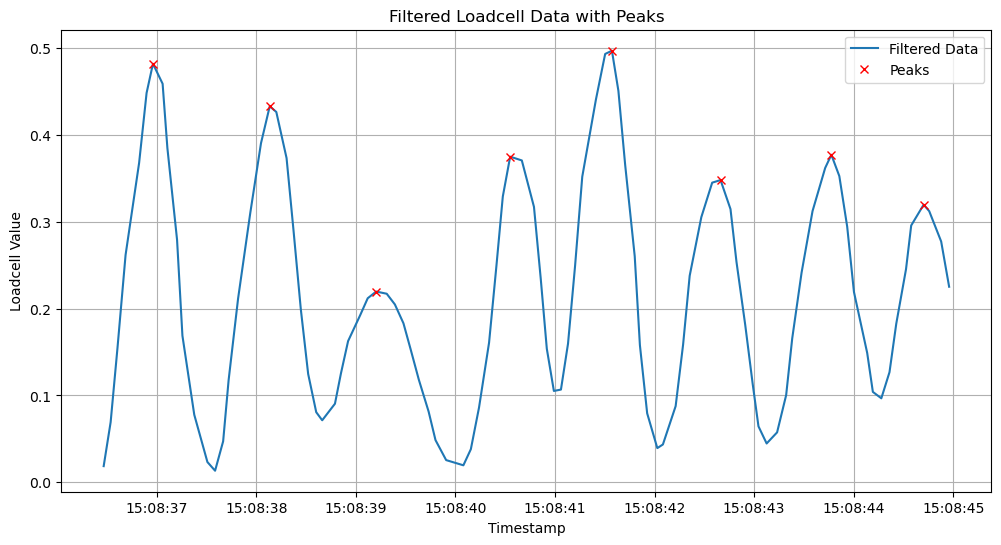

In [95]:
# finding the peaks in the filtered data
peaks, _ = spsig.find_peaks(filtered_data, height=0.05)  # find the peaks in the filtered data

# Adjust peaks to match the sliced range
adjusted_peaks = [p for p in peaks if time1 <= p < time2]

# plot the peaks in the filtered data
plt.figure(figsize=(12, 6))
plt.plot(log_df['Timestamp'][time1:time2], filtered_data[time1:time2], label='Filtered Data')
plt.plot(
	[log_df['Timestamp'][time1:time2].iloc[p - time1] for p in adjusted_peaks], 
	[filtered_data[p] for p in adjusted_peaks], 
	"x", label='Peaks', color='red'
)
plt.title('Filtered Loadcell Data with Peaks')
plt.xlabel('Timestamp')
plt.ylabel('Loadcell Value')
plt.legend()
plt.grid()
plt.show()

### Found peaks overlayed on all loadcell data

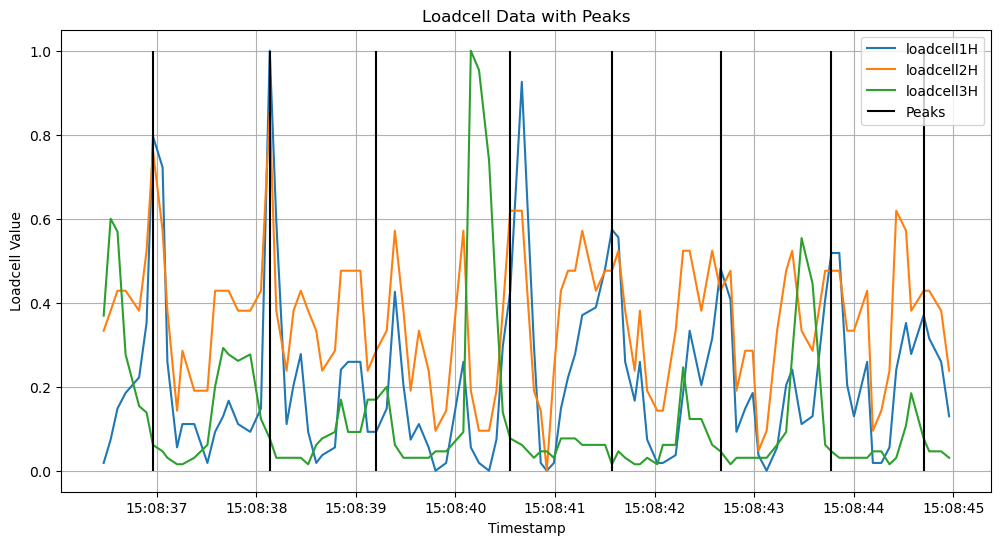

In [98]:
# overley the peaks with a red line on all of the loadcell data
plt.figure(figsize=(12, 6))
plt.plot(log_df['Timestamp'][time1:time2], log_df['loadcell1H'][time1:time2], label='loadcell1H')
plt.plot(log_df['Timestamp'][time1:time2], log_df['loadcell2H'][time1:time2], label='loadcell2H')
plt.plot(log_df['Timestamp'][time1:time2], log_df['loadcell3H'][time1:time2], label='loadcell3H')

# plot a red line on the x value for the peaks
plt.vlines(
    [log_df['Timestamp'][p] for p in adjusted_peaks if time1 <= p < time2], 
    0, 1, color='k', label='Peaks'
)
plt.title('Loadcell Data with Peaks')
plt.xlabel('Timestamp')
plt.ylabel('Loadcell Value')
plt.legend()
plt.grid()

### Calculating time of every cycle and average

In [99]:
# calculating the time between the peaks
peak_times = log_df['Timestamp'].iloc[adjusted_peaks]
peak_intervals = peak_times.diff().dt.total_seconds()  # time between the peaks in seconds
# remove NaN values from the peak intervals
peak_intervals = peak_intervals.dropna()
# print the peak intervals
print("Peak intervals (in seconds):")
print(peak_intervals)

# calculate the average time between the peaks
average_peak_interval = peak_intervals.mean()
print(f"Average time between peaks: {average_peak_interval} seconds")

Peak intervals (in seconds):
2119    1.173
2132    1.069
2147    1.346
2159    1.022
2172    1.091
2185    1.113
2196    0.927
Name: Timestamp, dtype: float64
Average time between peaks: 1.1058571428571429 seconds


## Machine learning

### train-test split
Splitting the data into a training set and a test set (validation)
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:
random_seed = 42
"""
x_train, x_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.33,
                                                    random_state=random_seed)
"""

### constructing model

In [ ]:
"""
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128,activation=tf.nn.relu,  
                                activity_regularizer=tf.keras.regularizers.L2(1e-5))) # change 128 based on amount of input vaiables
model.add(tf.keras.layers.Dense(128,activation=tf.nn.relu,
                                activity_regularizer=tf.keras.regularizers.L2(1e-5))) # play around whith size to see what works (overfit->smaller, underfit->larger(or add another layer))
model.add(tf.keras.layers.Dense(1,activation=tf.nn.softmax))

model.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) # could perhaps add loss here aswell
"""

### training model

In [ ]:
#model.fit(x_train,y_train,epochs=3) # probably add more epochs when we've found something that works

### validating model performance


In [ ]:
#val_loss, val_accuracy = model.evaluate(x_test,y_test)
#print(val_loss, val_accuracy)